# Machine Learning in Python - Roll your Own Estimator Example for TemplateMatchClassifier

This notebooks demonstrates how scikit-learn can be extended to include new models by implementing the **TemplateMatchClassifier**. 

The **TemplateMatchClassifier** is a **very basic** classification algorithm that calculates the average value of all descriptive features for all instances that have that target level in a training dataset and when asked to make a prediction returns the closet match(based on Euclidean distance) by comparing the descriptive feature values of the query instance to every target level in the template. 

The TemplateMatchClassifier is very simple:
* **Training:** For each target feature level calculate the average value of all descriptive features for instances that have that target level. Store these average vectors as templates for each target level.
* **Prediction:** When a new prediction needs to be made compare the descriptive feature values of the new query instance to each template and return the target feature level that belongs to the template that is cloesest (based on Euclidean distance) to the query case. 

**NOTE THAT THE TEMPLATEMATCHCLASSIFIER IS A TERRIBLE MODEL AND IS ONLY USED AS A VERY SIMPLE DEMONSTRATION OF HOW TO IMPLEMENT AN ML ALGORITHM IN SCIKIT-LEARN**

## Import Packages Etc

In [36]:
from IPython.display import display, HTML, Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import random
import sys

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from scipy.spatial import distance
from sklearn.neighbors import DistanceMetric

%matplotlib inline
#%qtconsole

## Define TemplateMatchClassifier

Define and test out the TemplateMatchClassifier class. To build a scikit-learn classifier we extend from the **BaseEstimator** and **ClassifierMixin** classes and implement the **init**, **fit**, **predict**, and **predict_proba** methods.

### Define the TemplateMatchClassifier Class

In [59]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class TemplateMatchClassifier(BaseEstimator, ClassifierMixin):
    """The TemplateMatchClassifier is a very basic classification algorithm that calculates the average value of all descriptive features for all instances that have that target level in a training dataset and when asked to make a prediction returns the closet match(based on Euclidean distance) by comparing the descriptive feature values of the query instance to every target level in the template. 
        - Training: For each target feature level calculate the average value of all descriptive features for instances that have that target level. Store these average vectors as templates for each target level.
        - Prediction: When a new prediction needs to be made compare the descriptive feature values of the new query instance to each template and return the target feature level that belongs to the template that is cloesest (based on Euclidean distance) to the query case. 

    Parameters
    ----------
    distanceMetric string, optional (default = 'euclidean')
        Which distance metric should be used for calculating the distance.

    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The class labels (single output problem).
    distribution_: dict
        A dictionary of the probability of each class.
    templateMap_ : dict
        A dictionary of the average distance of the featuers for each class.
        
    Notes
    -----
    

    See also
    --------
    
    ----------
    
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = TemplateMatchClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    
    # Constructor for the classifier object
    def __init__(self, distanceMetric = "euclidean"):
        self.distanceMetric = distanceMetric

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a decision tree classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like or sparse matrix, shape = [n_samples, n_features]
            The training input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csc_matrix``.
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """
            
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        # Count the number of occurrences of each class in the target vector (uses mupy unique function that returns a list of unique values and their counts)
        unique, counts = np.unique(y, return_counts=True)
        
        dist = counts/sum(counts)
        
        # Store the classes seen during fit
        self.classes_ = unique

        N = X.shape[1]
        target_classes = y
        target_classes = target_classes.reshape(target_classes.shape[0],-1)
        target_classes = target_classes.tolist()
        
        data = np.insert(X, [N], target_classes, axis=1)
        dataframe = pd.DataFrame(data)
        
        templateMap = {}
        
        #preparing the template map
        for target_class in unique:
            dff=dataframe.loc[dataframe[N]==float(target_class)]
            templateMap[target_class]=dff[dff.columns.difference([N])].mean().tolist()
   
        #store the template map
        self.templateMap_ = templateMap
        
        #preparing the class distribution
        self.distribution_ = dict(zip(unique, dist))
        
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like or sparse matrix of shape = [n_samples, n_features]
            The input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csr_matrix``.
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the distributions_ dictionary has been set up
        check_is_fitted(self, ['templateMap_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)

        # Initialise an empty list to store the predictions made
        predictions = list()
        
        # Iterate through the query instances in the query dataset 
        for instance in X:
            
            temp_val=sys.maxsize
            dlist=[]
            dist = DistanceMetric.get_metric(self.distanceMetric)
            
            for key in self.templateMap_:
                distance = dist.pairwise([self.templateMap_[key]], [instance])
                if distance[0][0] < temp_val:
                    temp_val=distance[0][0]
                    pred1 = key
        
            predictions.append(pred1)
            
        return np.array(predictions)
    
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        
        # Check is fit had been called by confirming that the distributions_ dictionary has been set up
        check_is_fitted(self, ['templateMap_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        # Initialise an array to store the prediction scores generated
        predictions = np.zeros((len(X), len(self.classes_)))

        # Iterate through the query instances in the query dataset 
        for idx, instance in enumerate(X):
            
            #Generate a random class according to the learned distribution
            pred = random.choices(list(self.distribution_.keys()), list(self.distribution_.values()))[0]

            # Always give the predicted class a probability of 0.9 and all other classes the remining probability mass  equally distributed.
            predictions[idx, ]= 0.1/(len(self.classes_) - 1)
            predictions[idx, list(self.classes_).index(pred)] = 0.9
            
        return predictions

## Load & Partition Data

### Setup - IMPORTANT

Take only a sample of the dataset for fast testing

In [43]:
data_sampling_rate = 0.1

Setup the number of folds for all grid searches (should be 5 - 10)

In [44]:
cv_folds = 2

In [45]:
dataset = pd.read_csv('fashion-mnist_train.csv')
dataset = dataset.sample(frac=data_sampling_rate) #take a sample from the dataset so everyhting runs smoothly
num_classes = 10
classes = {0: "T-shirt/top", 1:"Trouser", 2: "Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}
display(dataset.head())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
41056,1,0,0,0,0,0,0,0,0,0,...,162,37,0,0,0,0,0,0,0,0
58802,0,0,0,0,0,0,0,0,179,22,...,129,134,75,0,0,0,0,0,0,0
25840,0,0,0,0,0,0,0,0,0,0,...,90,94,106,75,0,0,0,0,0,0
21792,3,0,0,0,0,0,0,0,0,0,...,160,63,0,0,0,0,0,0,0,0
45822,6,0,0,0,0,0,0,0,2,0,...,67,71,81,8,0,0,0,0,0,0


In [46]:
X = dataset[dataset.columns.difference(["label"])]
Y = np.array(dataset["label"])

In [47]:
X = X/255

In [48]:
X_train_plus_valid, X_test, y_train_plus_valid, y_test \
    = train_test_split(X, Y, random_state=0, \
                                    train_size = 0.7)

X_train, X_valid, y_train, y_valid \
    = train_test_split(X_train_plus_valid, \
                                        y_train_plus_valid, \
                                        random_state=0, \
                                        train_size = 0.5/0.7)

/Users/prasad/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Train and Evaluate a Simple Model

In [56]:
my_model = TemplateMatchClassifier('euclidean')
my_model.fit(X_train, y_train)

TemplateMatchClassifier(distanceMetric='euclidean')

In [57]:
# Make a set of predictions for the training data
y_pred = my_model.predict(X_train)

# Print performance details
accuracy = metrics.accuracy_score(y_train, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_train, y_pred))

# Print confusion matrix
print(metrics.confusion_matrix(y_train, y_pred))

# Print nicer homemade confusion matrix
print("Confusion Matrix")
display(pd.crosstab(y_train, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.6926666666666667
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       308
           1       0.92      0.90      0.91       278
           2       0.66      0.43      0.52       316
           3       0.71      0.80      0.75       290
           4       0.46      0.63      0.53       283
           5       0.50      0.76      0.60       302
           6       0.38      0.19      0.25       293
           7       0.78      0.83      0.80       325
           8       0.93      0.78      0.84       289
           9       0.90      0.88      0.89       316

   micro avg       0.69      0.69      0.69      3000
   macro avg       0.70      0.69      0.68      3000
weighted avg       0.70      0.69      0.68      3000

[[225   3   1  26   4  32  15   0   2   0]
 [  5 249   1   9   4   7   3   0   0   0]
 [  0   1 136   3 100  43  29   0   4   0]
 [  7  13   0 233  13  13  10   0   1   0]
 [  1   2  42  26 178  10  23   0   1   

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,225,3,1,26,4,32,15,0,2,0,308
1,5,249,1,9,4,7,3,0,0,0,278
2,0,1,136,3,100,43,29,0,4,0,316
3,7,13,0,233,13,13,10,0,1,0,290
4,1,2,42,26,178,10,23,0,1,0,283
5,0,0,0,0,0,231,0,49,2,20,302
6,59,2,23,16,85,45,55,0,8,0,293
7,0,0,0,0,0,45,0,269,0,11,325
8,2,0,4,14,6,20,8,11,224,0,289


## Do a Cross Validation Experiment With Our Model

In [71]:
my_model = TemplateMatchClassifier()
scores = cross_val_score(my_model, X_train_plus_valid, y_train_plus_valid, cv=cv_folds, n_jobs=-1)
print(scores)

[0.66005666 0.7204611 ]


## Do a Grid Search Through Distance Metrics

In [58]:
# Set up the parameter grid to seaerch
param_grid = [
 {'distanceMetric': ['euclidean','manhattan','chebyshev','minkowski']}
]

# Perform the search
my_tuned_model = GridSearchCV(TemplateMatchClassifier(), param_grid, cv=10, verbose = 1, n_jobs=-1)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
print(my_tuned_model.best_score_)


Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best parameters set found on development set:
{'distanceMetric': 'euclidean'}
0.7021428571428572


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   49.4s finished


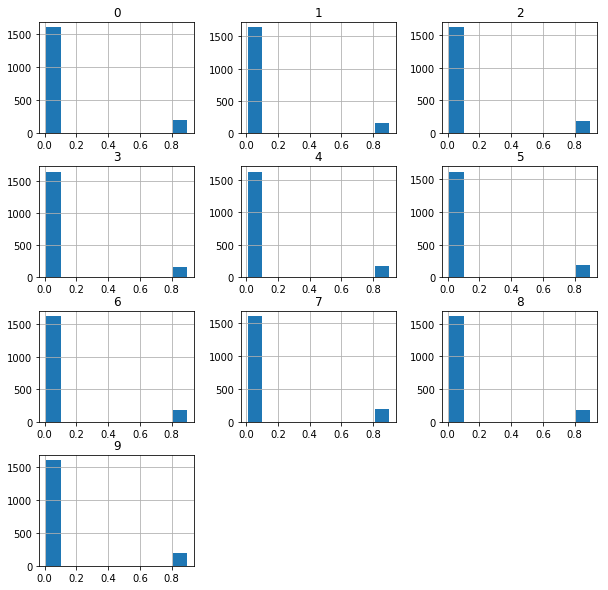

In [60]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict_proba(X_test)
_ = pd.DataFrame(y_pred).hist(figsize = (10,10))

In [62]:
dataset = pd.read_csv('fashion-mnist_test.csv')
dataset = dataset.sample(frac=data_sampling_rate) #take a sample from the dataset so everyhting runs smoothly
num_classes = 10
classes = {0: "T-shirt/top", 1:"Trouser", 2: "Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}
display(dataset.head())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
3370,3,0,0,0,0,0,0,0,0,0,...,96,17,0,0,0,0,0,0,0,0
6030,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4469,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4256,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8575,2,0,0,0,0,0,0,0,0,0,...,0,0,0,134,110,72,0,0,0,0


### Test the TemplateMatchClassifier

In [68]:
X_test = dataset[dataset.columns.difference(["label"])]
y_test = np.array(dataset["label"])

In [69]:
X_test = X_test/255

In [70]:
# Make a set of predictions for the training data
y_pred = my_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print(metrics.confusion_matrix(y_test, y_pred))

# Print nicer homemade confusion matrix
print("Confusion Matrix")
display(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.68
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       108
           1       0.94      0.92      0.93       102
           2       0.64      0.45      0.53       101
           3       0.70      0.71      0.70        96
           4       0.51      0.70      0.59        91
           5       0.53      0.78      0.63       120
           6       0.38      0.19      0.26        99
           7       0.73      0.75      0.74        93
           8       0.97      0.79      0.87        86
           9       0.84      0.85      0.84       104

   micro avg       0.68      0.68      0.68      1000
   macro avg       0.69      0.68      0.67      1000
weighted avg       0.68      0.68      0.67      1000

[[70  1  3 13  3 11  5  0  2  0]
 [ 4 94  0  1  0  1  2  0  0  0]
 [ 2  1 45  1 33  9 10  0  0  0]
 [ 8  3  0 68  4  6  7  0  0  0]
 [ 0  0 10  7 64  5  5  0  0  0]
 [ 0  0  0  0  0 94  0 17  0  9]
 [24  1 12  1 21 21 19  0  0

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,70,1,3,13,3,11,5,0,2,0,108
1,4,94,0,1,0,1,2,0,0,0,102
2,2,1,45,1,33,9,10,0,0,0,101
3,8,3,0,68,4,6,7,0,0,0,96
4,0,0,10,7,64,5,5,0,0,0,91
5,0,0,0,0,0,94,0,17,0,9,120
6,24,1,12,1,21,21,19,0,0,0,99
7,0,0,0,0,0,15,0,70,0,8,93
8,0,0,0,6,0,7,1,4,68,0,86
